# Summary

This notebook shows an implementation of the algorithm Isolation Forest and compares its other popular anomaly detection algorithms

Take the case of identifying the probability of an employee committing securities fraud. Here the behavioral data that the organization captures is very high dimensional and the relationship between the data points is complex. Hence without indepth domain knowledge, formulating risk rules is difficult. This combined with issues such as confidentiality makes it very hard to validate these risk rules.

This is where unsupervised learning shines. With very little domain knowledge, a simple unsupervised algorithm can be used to create a list of anomalies which can then be fed into an auditing process which then generates the true labels. Over time when enough data labels are created, the unsupervised problem can be reformulated as a supervised ML problem.

My personal summary of why to use supervised here:

Exploratory Data Analysis: Unsupervised learning can help you understand the structure or patterns within your data.

Anomaly Detection: Unsupervised learning is useful for detecting anomalies or unusual patterns in data, where you don't necessarily have labeled examples of what constitutes an anomaly

Pattern Discovery: If you want to uncover hidden patterns or relationships in your data without specific goals, unsupervised learning can be beneficial.

THE END GOAL IS TO USE THIS TO DETECT FRAUD ANOMALIES WITHOUT ANY LABELED DATA

In [1]:
import pandas as pd # IMPORTS
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
bankDF = pd.read_csv("../Base.csv") # Utilize the dataset that best represents the original dataset
bankDF.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


# Data Cleaning

Any NaNs? Any 0s that shouldn't be there?

In [7]:
bankDF.isna().any().any() # Clean data set, to be expected since it was synthetically generated

False

# Data Visualization

Take a closer look to see what we're dealing with

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

<AxesSubplot: ylabel='Frequency'>

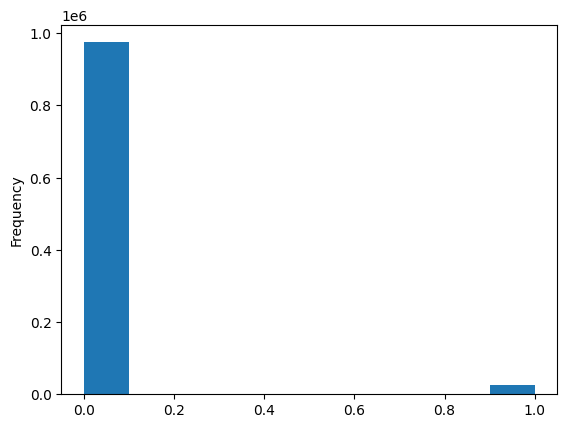

In [4]:
bankDF.foreign_request.plot.hist() # Seems to be very few foreign request, could be a sign of anomaly

<AxesSubplot: ylabel='Frequency'>

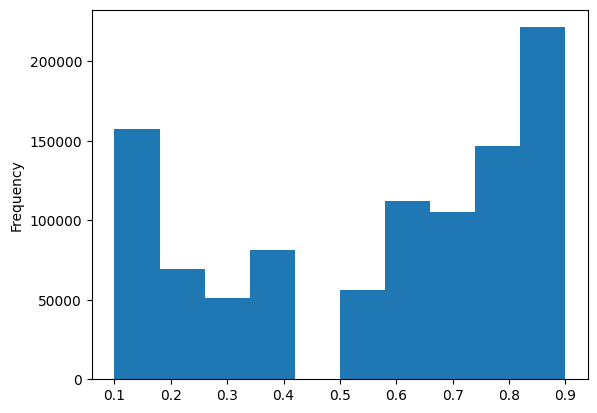

In [5]:
bankDF.income.plot.hist() # Not much to say here in terms of anomaly. Strange that a dataset this large is missing a bucket for a certain salary range though

<AxesSubplot: ylabel='Frequency'>

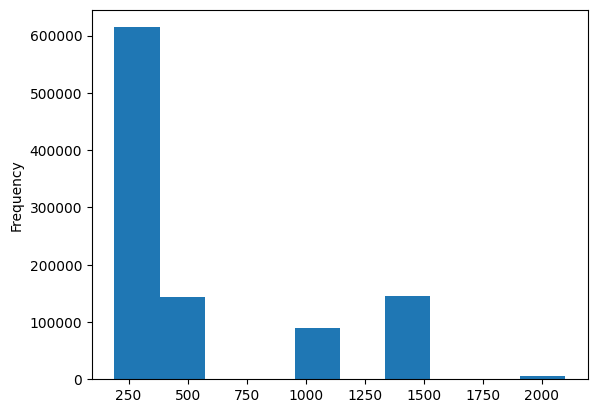

In [8]:
bankDF.proposed_credit_limit.plot.hist()

<AxesSubplot: >

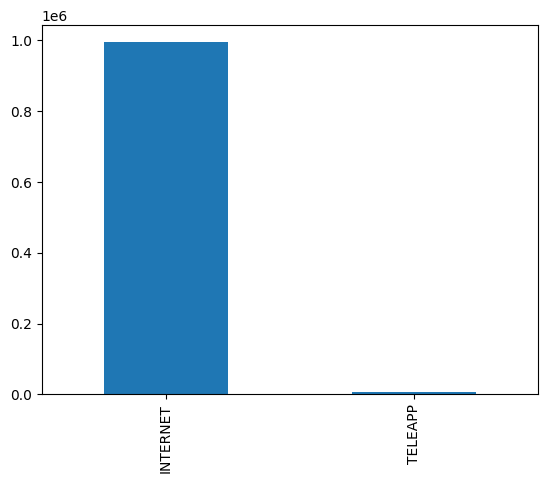

In [11]:
bankDF['source'].value_counts().plot(kind='bar') # Teleapp seems to be a VERY small minority, it's an anomaly but might not be fraud

<AxesSubplot: >

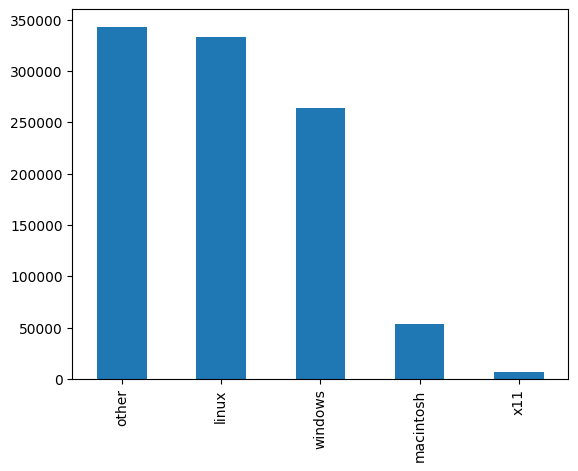

In [12]:
bankDF['device_os'].value_counts().plot(kind='bar') # Probably won't use this as a feature because it may just reflect popularity of a system rather than fraud

<AxesSubplot: ylabel='Frequency'>

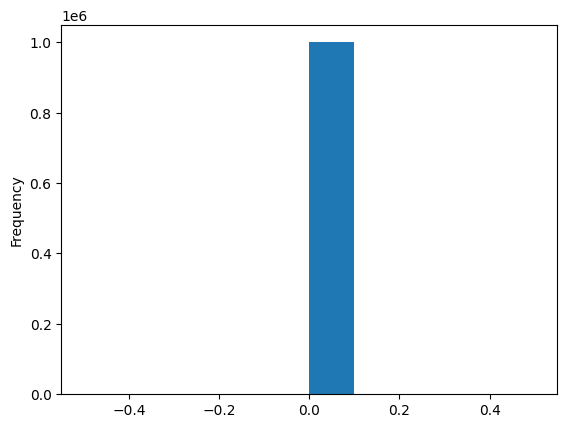

In [13]:
bankDF.device_fraud_count.plot.hist() # All at 0 as expected, if a device was flagged for fraud before then it's obvious

Text(0, 0.5, 'Frequency')

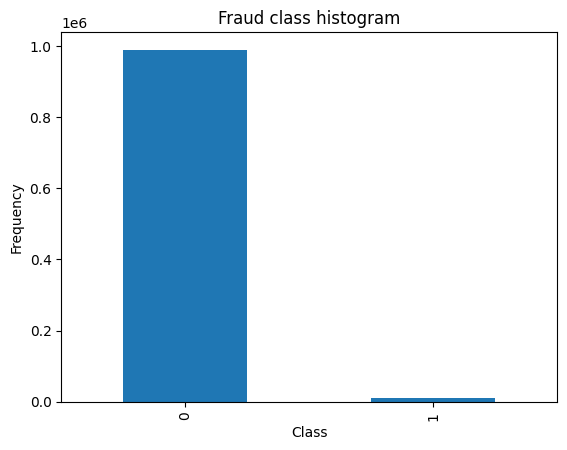

In [17]:
bankDF['fraud_bool'].value_counts().plot(kind='bar') # Very small portion of the data are fraud, makes sense since you wouldn't expect a large amount of a bank's applicants to be up to no good

plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Feature Engineering

Which features should we use to get the best results?